In [11]:
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from utils import create_features

In [2]:
data = pd.read_csv('../data/SOL-USD.csv')

In [3]:
filtered_df, feature_cols = create_features(data)

In [4]:
X_train = filtered_df[feature_cols]
y_train = filtered_df['Target']

params = {
    'objective': 'reg:squarederror',
    'tree_method': 'hist',
    'max_depth': 5,
    'learning_rate': 0.05,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 1,
    'n_jobs': -1
}

model = xgb.XGBRegressor(**params)
bst = model.fit(X_train, y_train)

In [5]:
joblib.dump(bst, '../models/xgb_model.joblib')

['../models/xgb_model.joblib']

In [6]:
future_days = 365
future_preds = []
simulated_prices = filtered_df.iloc[-1:].copy()  # start from last available row

hist_vol = filtered_df['Close'].pct_change().std()


for day in range(future_days):
    X_input = simulated_prices[feature_cols]
    
    # Predict next day return
    pred_return = model.predict(X_input)[0]
    pred_return = np.random.normal(pred_return, hist_vol)  # adding some noise
    future_preds.append(pred_return)
    
    # Simulate next day price (Close)
    next_close = simulated_prices['Close'].values[0] * (1 + pred_return)
    next_open = next_close  # simple approximation
    
    # Update High/Low (approximate)
    next_high = next_close * 1.01
    next_low  = next_close * 0.99
    
    # Shift lagged features
    simulated_prices = simulated_prices.copy()
    for col in ["Return_Open_1","Return_High_1","Return_Low_1","Return_Close_1"]:
        simulated_prices[col] = (next_close - simulated_prices['Close'].values[0]) / simulated_prices['Close'].values[0]
    
    # Update rolling features
    simulated_prices['Close'] = next_close
    simulated_prices['Open']  = next_open
    simulated_prices['High']  = next_high
    simulated_prices['Low']   = next_low
    simulated_prices['MA_Close_5_lag'] = (simulated_prices['MA_Close_5_lag'] * 4 + next_close)/5
    simulated_prices['Vol_Close_5_lag'] = np.std([simulated_prices['Close'].values[0], next_close])
    simulated_prices['HL_Ratio_5_lag'] = (next_high - next_low)/next_close
    simulated_prices['Close_vs_MA5_lag'] = next_close / simulated_prices['MA_Close_5_lag'] - 1
    simulated_prices['Rolling_High_5'] = next_high
    simulated_prices['Rolling_Low_5'] = next_low
    simulated_prices['Vol_High_5'] = 0.01  # small placeholder

In [7]:
initial_price = filtered_df['Close'].values[-1]
simulated_prices_list = [initial_price]

for r in future_preds:
    next_price = simulated_prices_list[-1] * (1 + r)
    simulated_prices_list.append(next_price)

cumulative_returns = np.array(simulated_prices_list) / initial_price - 1

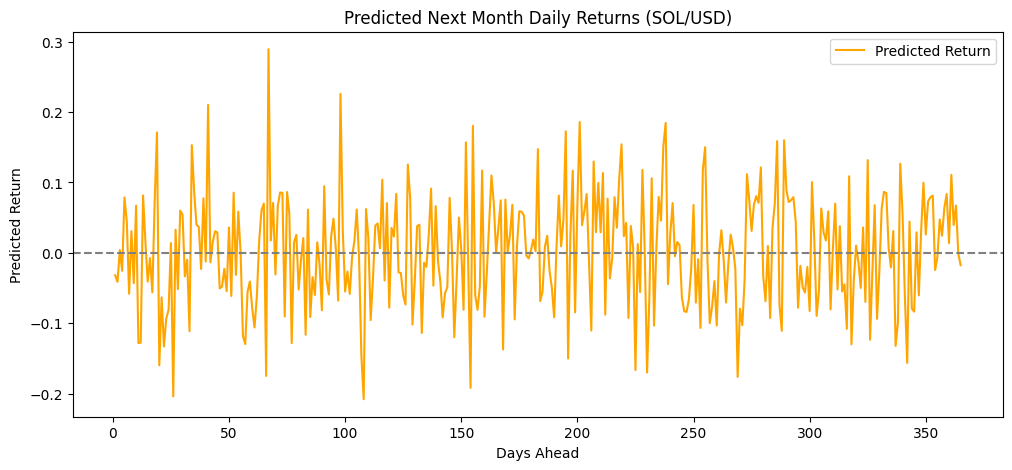

In [8]:
plt.figure(figsize=(12,5))
plt.plot(range(1,future_days+1), future_preds, label='Predicted Return', color='orange')
plt.title('Predicted Next Month Daily Returns (SOL/USD)')
plt.xlabel('Days Ahead')
plt.ylabel('Predicted Return')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.show()

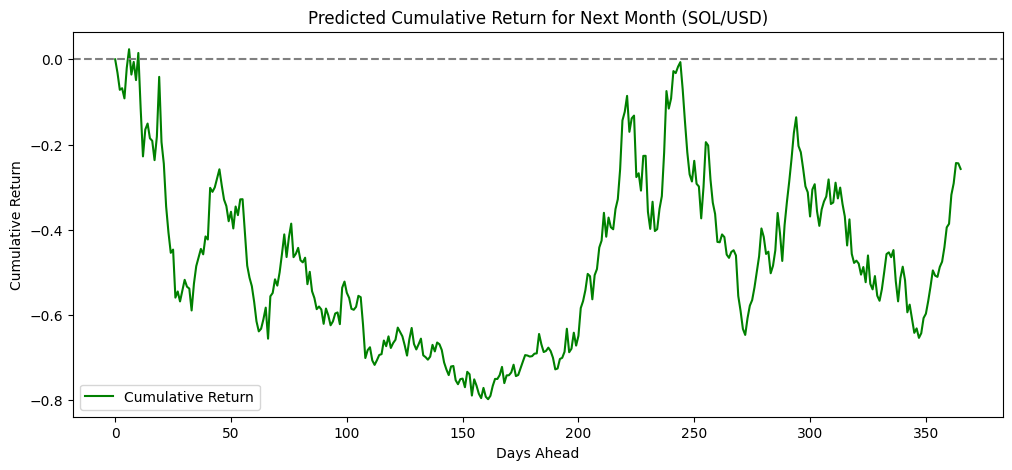

In [9]:
plt.figure(figsize=(12,5))
plt.plot(range(future_days+1), cumulative_returns, label='Cumulative Return', color='green')
plt.title('Predicted Cumulative Return for Next Month (SOL/USD)')
plt.xlabel('Days Ahead')
plt.ylabel('Cumulative Return')
plt.axhline(0, color='gray', linestyle='--')
plt.legend()
plt.show()

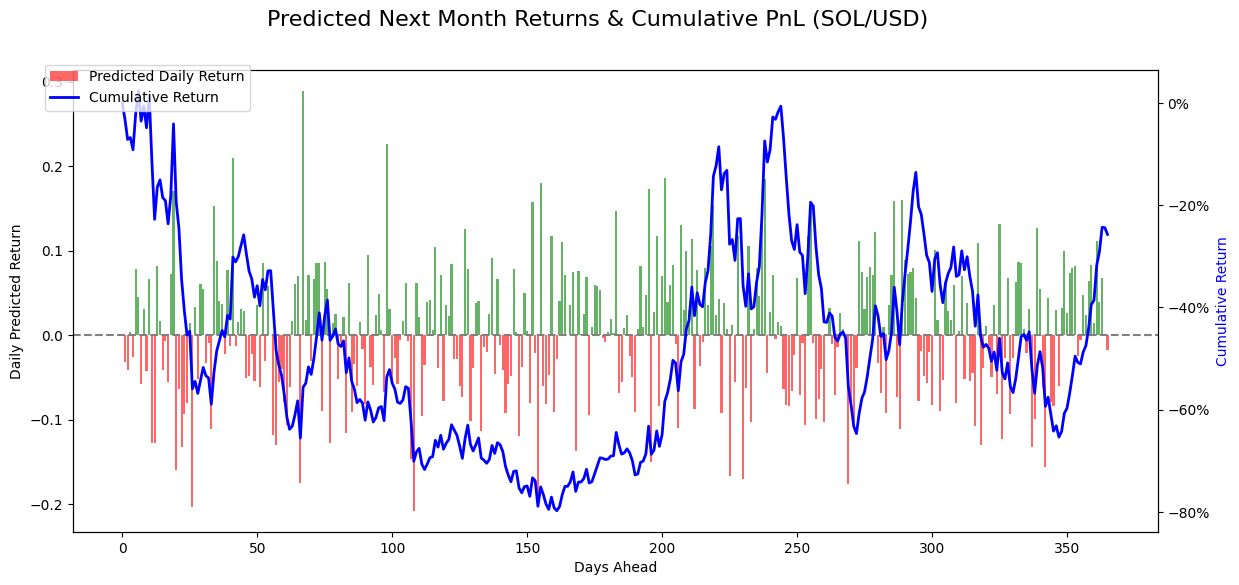

In [10]:
fig, ax1 = plt.subplots(figsize=(14,6))

# Daily predicted returns (bars)
colors = ['green' if r >= 0 else 'red' for r in future_preds]
ax1.bar(range(1, future_days+1), future_preds, color=colors, alpha=0.6, label='Predicted Daily Return')
ax1.set_xlabel('Days Ahead')
ax1.set_ylabel('Daily Predicted Return', color='black')
ax1.axhline(0, color='gray', linestyle='--')

# Cumulative return (line)
ax2 = ax1.twinx()
ax2.plot(range(future_days+1), cumulative_returns, color='blue', linewidth=2, label='Cumulative Return')
ax2.set_ylabel('Cumulative Return', color='blue')
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Title and legends
fig.suptitle('Predicted Next Month Returns & Cumulative PnL (SOL/USD)', fontsize=16)
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
plt.show()